<a href="https://colab.research.google.com/github/gulierus/RAD/blob/main/Homework_RAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.datasets import get_rdataset
from scipy.stats import t, norm

In [2]:
# 0. Load the MPG dataset from seaborn and drop rows with missing values for a clean baseline
cars = sns.load_dataset('mpg').dropna()

# Peek at the first rows to confirm structure
print(cars.head())

    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0    3504          12.0   
1  15.0          8         350.0       165.0    3693          11.5   
2  18.0          8         318.0       150.0    3436          11.0   
3  16.0          8         304.0       150.0    3433          12.0   
4  17.0          8         302.0       140.0    3449          10.5   

   model_year origin                       name  
0          70    usa  chevrolet chevelle malibu  
1          70    usa          buick skylark 320  
2          70    usa         plymouth satellite  
3          70    usa              amc rebel sst  
4          70    usa                ford torino  


In [3]:
# 1. Converting mpg values by adding new column L_per_100km in dataframe
cars['L_per_100km'] = 235.215 / cars['mpg']

print(cars[['mpg', 'L_per_100km']].head())

# Average fuel consumption in liters
avrg = cars['L_per_100km'].mean()
print(f'Average consumption: {avrg:.2f} L/100km')

    mpg  L_per_100km
0  18.0    13.067500
1  15.0    15.681000
2  18.0    13.067500
3  16.0    14.700938
4  17.0    13.836176
Average consumption: 11.25 L/100km


In [4]:
# 2. Converting horsepower values by adding new column kW in dataframe
cars['kW'] = cars['horsepower'] * 0.7355

print(cars[['horsepower', 'kW']].head())

# Range of engine power in kilowatts
rng = cars['kW'].max() - cars['kW'].min()
print(f'Range of power: {rng:.2f} kW')

   horsepower        kW
0       130.0   95.6150
1       165.0  121.3575
2       150.0  110.3250
3       150.0  110.3250
4       140.0  102.9700
Range of power: 135.33 kW


                            OLS Regression Results                            
Dep. Variable:            L_per_100km   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     1058.
Date:                Mon, 13 Oct 2025   Prob (F-statistic):          3.72e-113
Time:                        12:46:18   Log-Likelihood:                -833.48
No. Observations:                 392   AIC:                             1671.
Df Residuals:                     390   BIC:                             1679.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1682      0.297      7.290      0.0

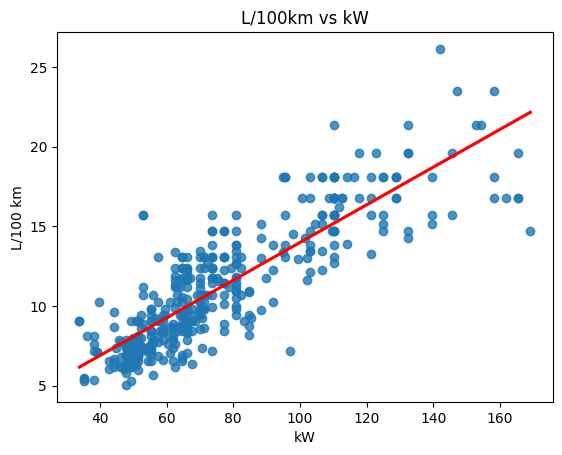

In [5]:
# 3. Regression analysis on how 'liters_per_100km' depends on 'kw'
df = cars[['kW', 'L_per_100km']].dropna()

x = df['kW'].to_numpy()
y = df['L_per_100km'].to_numpy()

model = smf.ols('L_per_100km ~ kW', data=df)
fit = model.fit()
print(fit.summary())

sns.regplot(x=x, y=y, data=df, ci=None, line_kws={"color": "red"})
plt.title('L/100km vs kW')
plt.xlabel('kW')
plt.ylabel('L/100 km')
plt.show()

From the OLS table we see that $β_0 = 2.1682$ and $β_1 = 0.1182$. It means that the reegression curve is up in the origin, which could be explained as $0$kW does not mean, that consuption is also $0$ so the model is more realistic. Also the CI says that our model is relatively confident for these estimated coeficients.

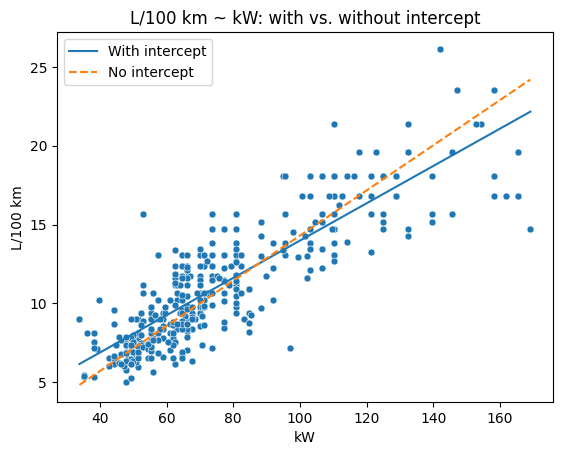

=== WITH intercept ===
                            OLS Regression Results                            
Dep. Variable:            L_per_100km   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     1058.
Date:                Mon, 13 Oct 2025   Prob (F-statistic):          3.72e-113
Time:                        12:46:19   Log-Likelihood:                -833.48
No. Observations:                 392   AIC:                             1671.
Df Residuals:                     390   BIC:                             1679.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1682      0.

In [6]:
# 4. The same regression analysis using a model with and without intercept
# OLS WITH intercept
mod_with = smf.ols('L_per_100km ~ kW', data=df).fit()

# OLS WITHOUT intercept
# In syntax, remove intercept by adding 0
mod_wo = smf.ols('L_per_100km ~ 0 + kW', data=df).fit()

# Plot data from dataframe
sns.scatterplot(x='kW', y='L_per_100km', data=df, s=25)

# Build x grid
xs = np.linspace(df['kW'].min(), df['kW'].max(), 200)

# Coefficients
b0 = mod_with.params['Intercept']
b1 = mod_with.params['kW']
y_with = b0 + b1 * xs

b1_wo = mod_wo.params['kW']
y_wo = b1_wo * xs

plt.plot(xs, y_with, label='With intercept')
plt.plot(xs, y_wo,  label='No intercept', linestyle='--')
plt.xlabel('kW')
plt.ylabel('L/100 km')
plt.title('L/100 km ~ kW: with vs. without intercept')
plt.legend()
plt.show()

# Shows key outputs for comparing (optional)
print("=== WITH intercept ===")
print(mod_with.summary())
print()

print("=== WITHOUT intercept ===")
print(mod_wo.summary())


The model **WITHOUT** intercept seems be better in fit the data. Also it seems that the **WITHOUT** model better cathes the trend around the origin of axes than the **WITH** model. But generally it should not be true and these improvments could be artificial because of how the parameteres were calculated. For futher explanation see the next section. Additionally you can compare other parametres in the OLS tables for these models.

In [7]:
# 5. the F-statistic and R-squared disscusion for both models

Here we see significant difference between two model in $R^2$ parameter.

Model **WITHOUT** intercept seems better because of higher $R^2$ value, but in other parametres as *Log-Likelihood* or *AIC* model **WITH** intercept gives us better values.

One of possible explanation is that model **WITHOUT** intercept will compute $R^2 = 1 - (SSR / SST)$, but $SST$ was computed with *zeros* insted of *average consumption*. So the model will compare data with $y=0$ instead of with *average L consumption per 100km* which implies $\frac{0L}{100km}$ při $0$ kW which should not be true in real life.

From F-test we can also conclude, that in both cases the p-value is very small (around zero), so the null hypotesis is rejected for both models which yields that *kW* affects on *fuel consumption*. Also values for *F-test* for **WITHOUT** model seems better, but we have concluded yet, that in this case we did wrong computations with zeros. In **WITH** model *F-test* values are also acteptable and explain the model in good level.

In [8]:
# 6. Test H0: Intercept - 10*kW = 0 for the regression coefficient
# Wald test
f_res = fit.f_test('Intercept - 10*kW = 0')
t_res = fit.t_test('Intercept - 10*kW = 0')

print("Wald F-test:", f_res)
print()
print("Wald t-test:", t_res)

Wald F-test: <F test: F=8.841240678311921, p=0.00312787405742915, df_denom=390, df_num=1>

Wald t-test:                              Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.9865      0.332      2.973      0.003       0.334       1.639


Reject null hypotesis because $p=0.003 < 0.05$ also CI is $[0.334; 16.39]$ and not containing $0$.

Conclusion: The intercept is statistically required, is not equal to $\beta_0 = 10\beta_1$ and proportional to power model does not explain the data.

In [9]:
#7. Comparing fuel consumption for cars from Europe and Japan
# origin = cars[cars['origin'].isin(['europe', 'japan'])].copy()

# # Split groups
# eu = origin.loc[origin['origin'] == 'europe', 'L_per_100km'].to_numpy()
# jp = origin.loc[origin['origin'] == 'japan',  'L_per_100km'].to_numpy()

# # Basic descriptive characteristics
# def desc(x):
#     return dict(n=len(x), mean=float(np.mean(x)), std=float(np.std(x, ddof=1)))
# eu_desc, jp_desc = desc(eu), desc(jp)
# print("EU:", eu_desc)
# print("JP:", jp_desc)
# print()

# # Welch two sample t-test
# tt = stats.ttest_ind(eu, jp, equal_var=False)
# print("Welch t-test:", tt)


df = cars[['L_per_100km','kW','origin']].dropna()
orogin = df[df['origin'].isin(['europe','japan'])].copy()

m = smf.ols('L_per_100km ~ kW * C(origin)', data=df).fit()
p = m.params

d0 = p['C(origin)[T.japan]']             # difference in \beta_0 (JP - EU)
d1 = p['kW:C(origin)[T.japan]']          # difference in \beta_1 (JP - EU)

# Intersection ( EU == JP): 0 = d0 + d1 * x  =>  x* = -d0/d1
x_star = -d0 / d1

print('x* (kW) where EU == JP:', x_star)

if d1 > 0:
    print('EU < JP for kW >', x_star)
else:
    print('EU < JP for kW <', x_star)


x* (kW) where EU == JP: -13.184115872381378
EU < JP for kW < -13.184115872381378


Conclusion: EU < JP is true only in negative number, so for our data it means, that EU $\geq$ JP that means that consumpiton in EU is greater than in JP for all kW from the data. For comparing in each group in more sophisticated way we could use the binning technique.

In [10]:
# 8. Investigation the impact of weight on fuel consumption
weight = cars[['L_per_100km','kW','weight']].dropna().copy()

m_restr = smf.ols('L_per_100km ~ kW', data=weight).fit()
m_full  = smf.ols('L_per_100km ~ kW + weight', data=weight).fit()

print(m_restr.summary())
print(m_full.summary())

F, p, weight_diff = m_full.compare_f_test(m_restr)
print(f'Partial F for weight: F={F:.3f}, p={p:.4g}, df_diff={weight_diff}')

                            OLS Regression Results                            
Dep. Variable:            L_per_100km   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     1058.
Date:                Mon, 13 Oct 2025   Prob (F-statistic):          3.72e-113
Time:                        12:46:19   Log-Likelihood:                -833.48
No. Observations:                 392   AIC:                             1671.
Df Residuals:                     390   BIC:                             1679.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1682      0.297      7.290      0.0

Conclusion:
The full model explains the data better, higher $R^2$ and $R^2_{adj}$, much lower AIC, highly significant growth fit by weight.
Adding weight turns the *kW* coefficient into a partial effect: “*per-1 kW increase holding weight fixed.*”

In [11]:
#9. Prediction of the fuel consumption of a car with 150 kW engine power
cars = cars[['L_per_100km','kW','weight','origin']].dropna().copy()
allorig = cars[cars['origin'].isin(['usa','europe','japan'])]

# Model with origin
m = smf.ols('L_per_100km ~ kW + weight + C(origin)', data=allorig).fit()

# Predict at 150 kW, weight fixed at overall mean
w_mean = float(allorig['weight'].mean())
X = pd.DataFrame({
    'kW': [150,150,150],
    'weight': [w_mean,w_mean,w_mean],
    'origin': ['usa','europe','japan'],
})
pred = m.get_prediction(X).summary_frame(alpha=0.05)

# Show mean and lower/upper CI bounds
out = pd.concat([X, pred[['mean','obs_ci_lower','obs_ci_upper']]], axis=1)
print(out)

# Plot regression for each orgin (optional)
# xs = np.linspace(allorig['kW'].min(), allorig['kW'].max(), 200)

# plt.scatter(allorig['kW'], allorig['L_per_100km'], s=10, alpha=0.25, label='data')

# for orig in ['usa','europe','japan']:
#     grid = pd.DataFrame({'kW': xs, 'weight': w_mean, 'origin': orig})
#     yhat = m.predict(grid)
#     plt.plot(xs, yhat, label=orig)

# plt.xlabel('kW')
# plt.ylabel('L/100 km')
# plt.title('Predicted L/100 km vs kW (weight fixed at mean)')
# plt.legend()
# plt.show()


    kW       weight  origin       mean  obs_ci_lower  obs_ci_upper
0  150  2977.584184     usa  15.085449     11.652427     18.518471
1  150  2977.584184  europe  14.945947     11.494366     18.397527
2  150  2977.584184   japan  14.575788     11.142140     18.009436


Conclusion: We choosed the classic $α=0.05$ test level. Those $95\%$ prediction intervals give the range where a single new car with the same inputs is expected to fall about $95\%$ of the time. The intervals are wide and largely overlapping, so origin differences at fixed weight are small relative to residual variability.